# LIGO Gravitational Wave Analysis

Based on pycbc examples:

* https://pycbc.org/pycbc/latest/html/inference.html
* https://github.com/gwastro/PyCBC-Tutorials/blob/master/tutorial/inference_0_Overview.ipynb
* https://github.com/gwastro/PyCBC-Tutorials/

In [1]:
!pip install pycbc

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [8]:
!pip3 uninstall -y emcee
!pip3 install emcee==2.2.0

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Found existing installation: emcee 3.1.0
Uninstalling emcee-3.1.0:
  Successfully uninstalled emcee-3.1.0
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Created wheel for emcee: filename=emcee-2.2.0-py3-none-any.whl size=29250 sha256=d4b4e7dde9d448e563cff0bd66e

In [1]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW150914")

# List of observatories we'll analyze
ifos = ['H1', 
        #'V1', 
        'L1',
       ]

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True) 

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd





Processing H1 data


RuntimeError: Internal function call failed: Invalid argument

In [35]:
data

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f80fa8ebe80>,
 'V1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f80fa881ac0>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f80fa881bb0>}

In [73]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, UniformAngle, SinAngle, CosAngle, UniformLog10

static = {'f_lower':25.0,
          'approximant':"TaylorF2",
          'f_final':500,
          'polarization':0,
         }

# parameters:
variable = (
    'tc',
    'ra',
    'dec',
    'distance',
    'mchirp',
    'q',
    'inclination',
    #'polarization',
)

# prior distribution:
prior = JointDistribution(variable, 
    SinAngle(inclination=None),
    UniformAngle(ra=None),
    UniformLog10(mchirp=(0.1, 100), q=(0.1, 10.)),
    CosAngle(dec=None),
    Uniform(
        distance=(10, 100),
        tc=(m.time+.02, m.time+0.05),
    ),
)

from pycbc.transforms import MchirpQToMass1Mass2

# use only some of the data (without Virgo):
partial_data = dict(data)
#del partial_data['V1']

# which model to fit to the data
model = models.MarginalizedPhaseGaussianNoise(
    variable,
    partial_data,
    low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25},
    high_frequency_cutoff = {'H1':500, 'L1':500, 'V1':500},
    psds = psds,
    static_params = static,
    prior = prior,
    waveform_transforms = [MchirpQToMass1Mass2()]
)



In [74]:
from pycbc.inference.sampler.emcee import EmceeEnsembleSampler
from pycbc.inference.sampler import UltranestSampler

In [60]:
smpl = EmceeEnsembleSampler(model, 200, nprocesses=8)
_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!


In [76]:
smpl.clear_samples()

In [77]:
# Note it may take ~1-3 minutes for this to run
smpl.run_mcmc(200)

In [78]:
smpl.sampling_params

('tc', 'ra', 'dec', 'distance', 'mchirp', 'q', 'inclination')

In [79]:
smpl.samples

{'tc': array([[1.18700888e+09, 1.18700888e+09, 1.18700888e+09, ...,
         1.18700888e+09, 1.18700888e+09, 1.18700888e+09],
        [1.18700888e+09, 1.18700888e+09, 1.18700888e+09, ...,
         1.18700888e+09, 1.18700888e+09, 1.18700888e+09],
        [1.18700888e+09, 1.18700888e+09, 1.18700888e+09, ...,
         1.18700888e+09, 1.18700888e+09, 1.18700888e+09],
        ...,
        [1.18700888e+09, 1.18700888e+09, 1.18700888e+09, ...,
         1.18700888e+09, 1.18700888e+09, 1.18700888e+09],
        [1.18700888e+09, 1.18700888e+09, 1.18700888e+09, ...,
         1.18700888e+09, 1.18700888e+09, 1.18700888e+09],
        [1.18700888e+09, 1.18700888e+09, 1.18700888e+09, ...,
         1.18700888e+09, 1.18700888e+09, 1.18700888e+09]]),
 'ra': array([[1.81707336, 1.81707336, 1.71627293, ..., 1.28539824, 1.28539824,
         1.28539824],
        [3.57669527, 3.57669527, 3.57669527, ..., 3.57417708, 3.57417708,
         3.57417708],
        [2.81414213, 2.81414213, 2.81414213, ..., 2.00349451,

In [80]:
import numpy as np
%matplotlib inline

In [81]:
flat_samples = np.transpose([smpl.samples[k].flatten() for k in smpl.sampling_params])
flat_samples.shape

(40000, 7)

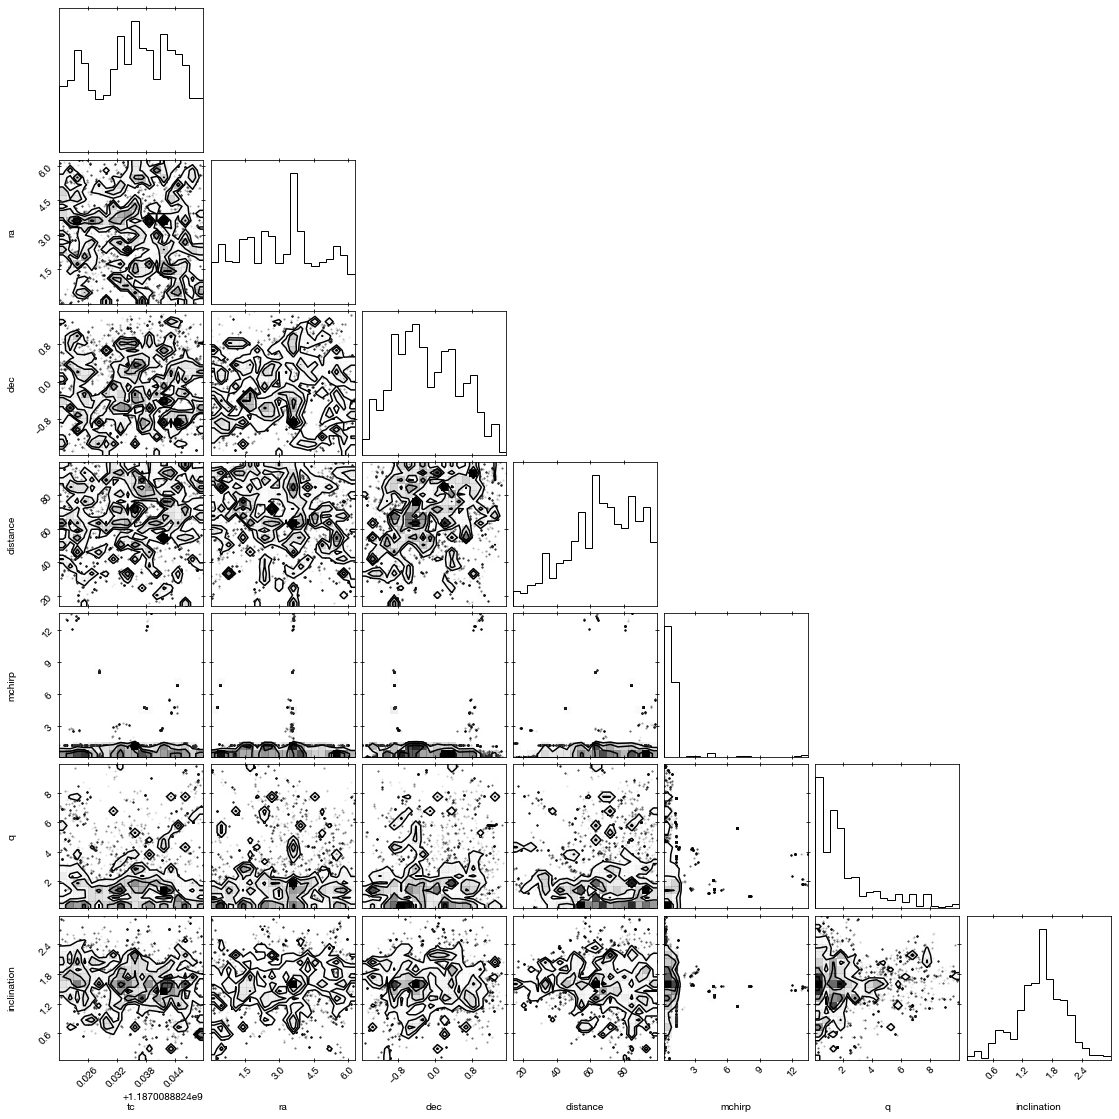

In [82]:
import corner
corner.corner(flat_samples[10000:,:], labels=smpl.sampling_params);

In [83]:
#from pycbc.inference.sampler import DynestySampler
#sampler = DynestySampler(model, nlive=400)
#sampler.run()

In [84]:
sampler = UltranestSampler(model, log_dir='LIGOfull8')

In [ ]:
sampler.run()

[ultranest] Sampling 400 live points from prior ...


## Exercise 1: MCMC

* Run MCMC for a number of iterations.
* Plot the posterior distribution (with getdist or corner or arviz).
* You constrained the position of this event on the sky (RA, Dec). Compute error bars. Show a picture of that part of the sky with the error ellipse 
  * (You can use https://github.com/cds-astro/ipyaladin or show a image or include a html/script via %%html).
* use the methods learned earlier to investigate whether the chain has converged

## Exercise 2: Nested Sampling

* Run the UltranestSampler `UltranestSampler(model, log_dir='my-results-directory', stepsampling=True)`. If it is slow, run with MPI (`mpiexec -np 8 python3 myscript.py`).
* Plot the posterior distributions (with getdist or corner or arviz).
* Compute the information gain for each parameter compared to the prior.
* vary the data sets, by only using one or two of the LIGO/VIRGO detectors: What constraints can be obtained then?

## Homework: Compare at least two samplers

Select a inference problem. 

You can either 
a) Use the LIGO problem above or
b) choose your own problem. In that case, use a simplified version.

Implement inference with two of the three techniques (Importance Sampling, MCMC, Nested Sampling) and run them until convergence. You can use your own implementations, but include at least one modern sampler (for example: ultranest, dynesty, multinest, zeus, emcee, autoemcee, snowline). 

* Compare their performance qualitatively: ease of use, correctness of the result
* Compare their performance quantitatively: number of effective samples per wall-clock time
* Make at least one variation of a sampler tuning parameter (number of walkers).
